<a href="https://colab.research.google.com/github/fjadidi2001/Artificial_Intelligence_Learning/blob/master/SVD_inpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# libraries

In [89]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
from matplotlib.image import imread
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import cv2
import cv2 as cv
from sklearn.decomposition import SparseCoder
from skimage.util import view_as_windows


# load image

In [90]:
def read_image(image_path):
    return io.imread(image_path)

# Gray level

In [91]:
def convert_to_grayscale(image):
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        return image
    return color.rgb2gray(image)


# mask

In [92]:
def create_mask(image_shape, mask_coords):
    mask = np.zeros(image_shape, dtype=bool)
    for (x, y, w, h) in mask_coords:
        mask[y:y+h, x:x+w] = True
    return mask


# patches

In [93]:

def extract_patches(image, patch_size):
    patches = view_as_windows(image, (patch_size, patch_size), step=patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)
    return patches


# SVD

In [94]:
def perform_svd(patches):
    U_list, S_list, Vt_list = [], [], []
    for patch in patches:
        U, S, Vt = np.linalg.svd(patch, full_matrices=False)
        U_list.append(U)
        S_list.append(S)
        Vt_list.append(Vt)
    return U_list, S_list, Vt_list


# PCA

In [95]:
def perform_pca(patches, n_components):
    pca = PCA(n_components=n_components)
    patches_flat = patches.reshape(patches.shape[0], -1)
    pca.fit(patches_flat)
    return pca.components_, pca.mean_, pca

# patches from SVD

In [96]:
def reconstruct_patches_svd(U_list, S_list, Vt_list, k):
    reconstructed_patches = []
    for U, S, Vt in zip(U_list, S_list, Vt_list):
        S_k = np.zeros_like(S)
        S_k[:k] = S[:k]
        reconstructed_patch = np.dot(U, np.dot(np.diag(S_k), Vt))
        reconstructed_patches.append(reconstructed_patch)
    return np.array(reconstructed_patches)


# patches from PCA

In [97]:
def reconstruct_patches_pca(patches, components, mean, pca):
    patches_flat = patches.reshape(patches.shape[0], -1)
    patches_reconstructed_flat = pca.inverse_transform(pca.transform(patches_flat))
    return patches_reconstructed_flat.reshape(patches.shape)


# inpaint

In [98]:
def inpaint(image, mask, patch_size, k, method='svd'):
    patches = extract_patches(image, patch_size)
    if method == 'svd':
        U_list, S_list, Vt_list = perform_svd(patches)
        reconstructed_patches = reconstruct_patches_svd(U_list, S_list, Vt_list, k)
    elif method == 'pca':
        components, mean, pca = perform_pca(patches, k)
        reconstructed_patches = reconstruct_patches_pca(patches, components, mean, pca)
    else:
        raise ValueError("Unsupported method. Use 'svd' or 'pca'.")

    reconstructed_image = np.copy(image)
    patch_index = 0
    for i in range(0, image.shape[0] - patch_size + 1, patch_size):
        for j in range(0, image.shape[1] - patch_size + 1, patch_size):
            if mask[i:i+patch_size, j:j+patch_size].any():
                reconstructed_image[i:i+patch_size, j:j+patch_size] = reconstructed_patches[patch_index]
            patch_index += 1
    return reconstructed_image


# display images

In [99]:
def display_images(original_image, masked_image, inpainted_image, patches):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs[0, 0].imshow(original_image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(masked_image, cmap='gray')
    axs[0, 1].set_title('Masked Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(inpainted_image, cmap='gray')
    axs[0, 2].set_title('Inpainted Image')
    axs[0, 2].axis('off')

    for idx, patch in enumerate(patches[:3]):
        axs[1, idx].imshow(patch, cmap='gray')
        axs[1, idx].set_title(f'Patch {idx+1}')
        axs[1, idx].axis('off')

    plt.show()


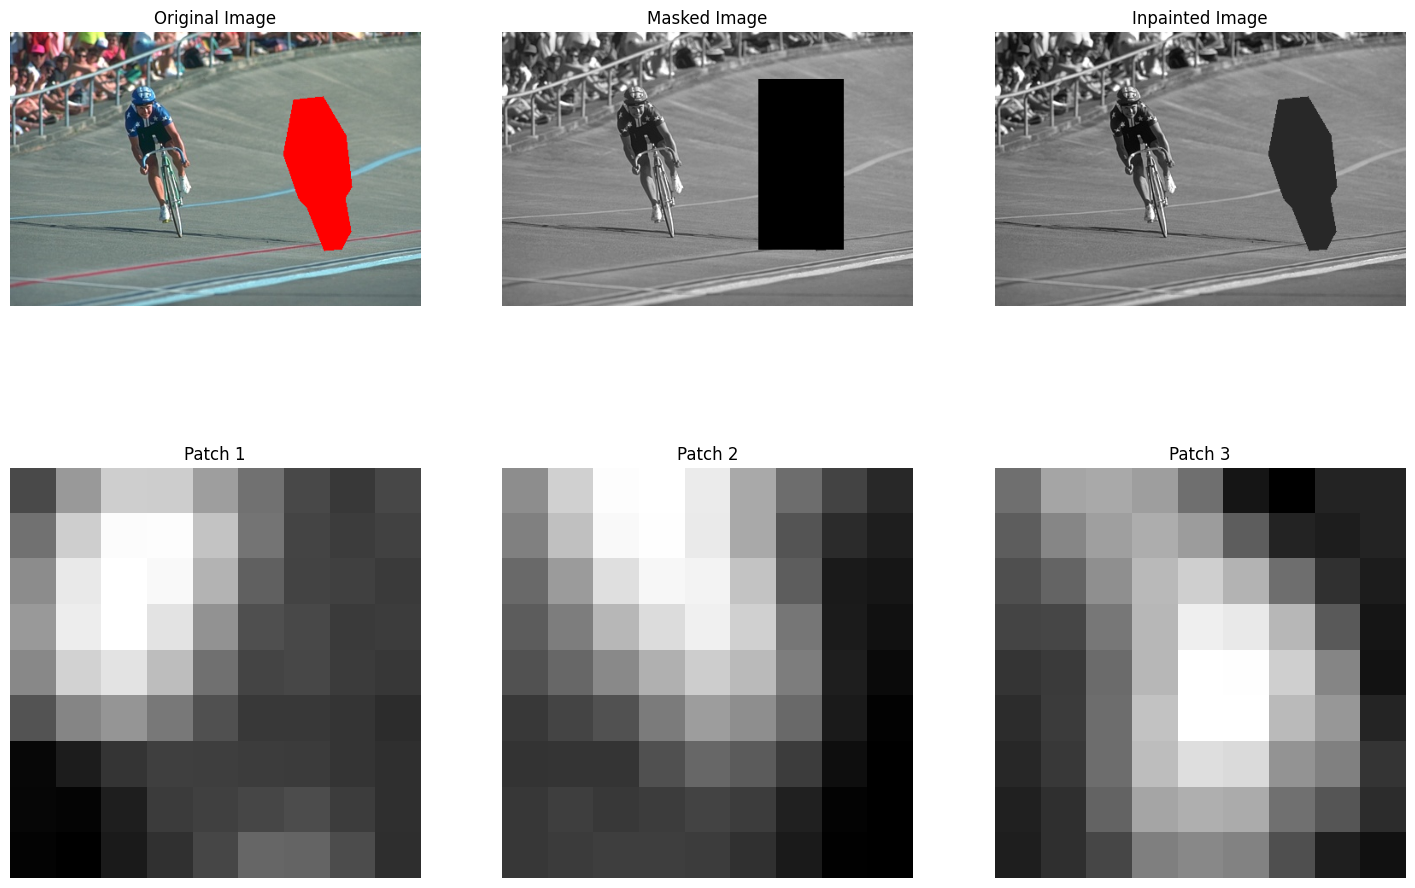

In [100]:
def main(image_path, mask_coords, patch_size, k, method='svd'):
    original_image = read_image(image_path)
    grayscale_image = convert_to_grayscale(original_image)
    mask = create_mask(grayscale_image.shape, mask_coords)
    masked_image = np.copy(grayscale_image)
    masked_image[mask] = 0
    inpainted_image = inpaint(grayscale_image, mask, patch_size, k, method)
    patches = extract_patches(grayscale_image, patch_size)
    display_images(original_image, masked_image, inpainted_image, patches)

# Example Usage
image_path = '22.png'
mask_coords = [(300, 55, 100, 200)]  # Example coordinates (x, y, width, height)
patch_size = 9  # Example patch size
k = 50  # Top k% singular values to keep for SVD or top k principal components for PCA
method = 'svd'  # or 'pca'
main(image_path, mask_coords, patch_size, k, method)

